# Проект по "Введению в финансовые рынки" по теме "Дебиторская задолженность"

### **0. Установка зависимостей**

Зависимости и их версии перечислены в файле `requirements.txt`

In [ ]:
!pip3 install -r requirements.txt

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns
import optuna

from catboost import CatBoostClassifier, Pool

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, mean_absolute_error, r2_score, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor


### **1. Ознакомление с данными и их предварительная обработка**

In [2]:
dataset_path = './data/ar_dataset.csv'
data = pd.read_csv(dataset_path)
data.head(10)

,countryCode,customerID,PaperlessDate,invoiceNumber,InvoiceDate,DueDate,InvoiceAmount,Disputed,SettledDate,PaperlessBill,DaysToSettle,DaysLate
0,391,0379-NEVHP,4/6/2013,611365,1/2/2013,2/1/2013,55.94,No,1/15/2013,Paper,13,0
1,406,8976-AMJEO,3/3/2012,7900770,1/26/2013,2/25/2013,61.74,Yes,3/3/2013,Electronic,36,6
2,391,2820-XGXSB,1/26/2012,9231909,7/3/2013,8/2/2013,65.88,No,7/8/2013,Electronic,5,0
3,406,9322-YCTQO,4/6/2012,9888306,2/10/2013,3/12/2013,105.92,No,3/17/2013,Electronic,35,5
4,818,6627-ELFBK,11/26/2012,15752855,10/25/2012,11/24/2012,72.27,Yes,11/28/2012,Paper,34,4
5,818,5148-SYKLB,8/28/2013,18104516,1/27/2012,2/26/2012,94.00,Yes,2/22/2012,Paper,26,0
6,897,8690-EEBEO,12/5/2012,23864272,8/13/2013,9/12/2013,74.69,No,9/9/2013,Electronic,27,0
7,770,4460-ZXNDN,6/27/2013,27545037,12/16/2012,1/15/2013,75.06,No,1/12/2013,Paper,27,0
8,770,3831-FXWYK,3/8/2013,28049695,5/14/2012,6/13/2012,80.07,Yes,7/1/2012,Paper,48,18
9,897,7654-DOLHO,4/4/2012,32277701,7/1/2013,7/31/2013,48.33,No,7/26/2013,Electronic,25,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2466 entries, 0 to 2465
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   countryCode    2466 non-null   int64  
 1   customerID     2466 non-null   object 
 2   PaperlessDate  2466 non-null   object 
 3   invoiceNumber  2466 non-null   int64  
 4   InvoiceDate    2466 non-null   object 
 5   DueDate        2466 non-null   object 
 6   InvoiceAmount  2466 non-null   float64
 7   Disputed       2466 non-null   object 
 8   SettledDate    2466 non-null   object 
 9   PaperlessBill  2466 non-null   object 
 10  DaysToSettle   2466 non-null   int64  
 11  DaysLate       2466 non-null   int64  
dtypes: float64(1), int64(4), object(7)
memory usage: 231.3+ KB


### Описание полей датасета

+ `countryCode`: Код страны клиента.
+ `customerID`: Уникальный идентификатор клиента.
+ `PaperlessDate`: Дата перехода на электронные счета.
+ `invoiceNumber`: Номер счета.
+ `InvoiceDate`: Дата создания счета.
+ `DueDate`: Дата, к которой нужно было оплатить счет.
+ `InvoiceAmount`: Сумма счета.
+ `Disputed`: Указывает, был ли счет оспорен.
+ `SettledDate`: Дата оплаты счета.
+ `PaperlessBill`: Тип счета (бумажный / электронный).
+ `DaysToSettle`: Количество дней, которое потребовалось для оплаты счета.
+ `DaysLate`: Количество дней просрочки оплаты.

Преобразовываем столбцы с датой и временем в нужный нам формат

In [4]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data['DueDate'] = pd.to_datetime(data['DueDate'])
data['SettledDate'] = pd.to_datetime(data['SettledDate'])

Вычисляем DaysOverdue для проверки корректности DaysLate, учета пропусков и создания более гибких таргетов для анализа и моделей

In [5]:
data['DaysOverdue'] = (data['SettledDate'] - data['DueDate']).dt.days.clip(lower=0)

Сравниваем

In [ ]:
data.loc[data['DaysOverdue'] != data['DaysLate'], ['DaysOverdue', 'DaysLate']]

Так-как `DaysOverdue` и `DaysLate` корректны - продолжаем работу с `DaysLate`.

У нас есть таргет для регрессии DaysLate, но ещё нужен бинарный таргет для классификации того, была ли компанией просрочена оплата ранее или нет. Таковым будет являться `OnTimePayment`.

In [7]:
data['OnTimePayment'] = (data['DaysLate'] > 0).astype(int)
data[['customerID','DaysLate','OnTimePayment']]

,customerID,DaysLate,OnTimePayment
0,0379-NEVHP,0,0
1,8976-AMJEO,6,1
2,2820-XGXSB,0,0
3,9322-YCTQO,5,1
4,6627-ELFBK,4,1
...,...,...,...
2461,6708-DPYTF,14,1
2462,9841-XLGBV,0,0
2463,7856-ODQFO,0,0
2464,7050-KQLDO,0,0


Посмотрим на корреляцию между суммой счета, количеством дней оплаты счета и просрочкой оплаты

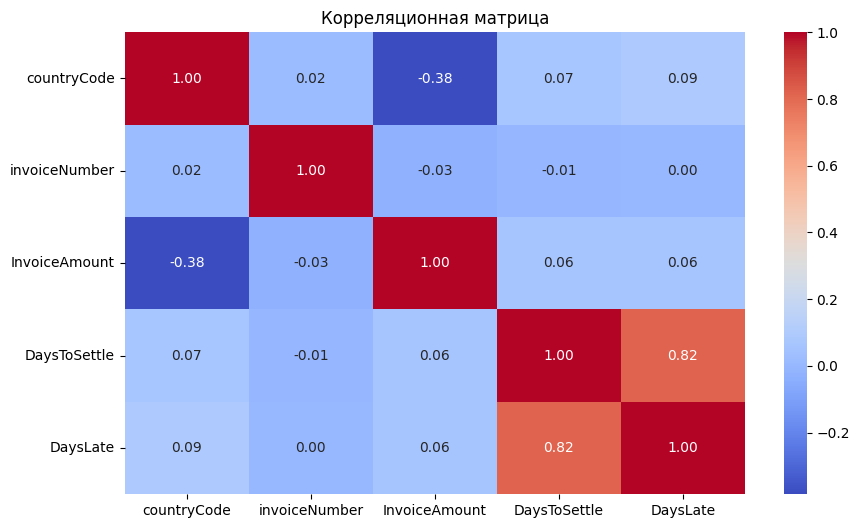

In [8]:
correlation = data.loc[:, ~data.columns.isin(['OnTimePayment', 'DaysOverdue'])].corr(numeric_only=True)
plt.figure(figsize=(10, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Корреляционная матрица")
plt.show()

По тепловой карте можно понять, что:
 + `DaysToSettle` имеет высокую положительную корреляцию с `DaysLate` (0.82).
     * Это ожидаемо, так как количество дней урегулирования связано с задержками.(т.е. нам не нужен этот признак для обучения модели)
 + `InvoiceAmount` имеет слабую положительную корреляцию с `DaysLate` (0.06)
     * Это может указывать на слабое влияние размера счета на просрочку.
 + `countryCode` тоже имеет положительную корреляцию с `DaysLate` (0.09)
     * Это может указывать на некоторое влияние страны компании на просрочку.
 + `InvoiceNumber` никак не коррелирует с `DaysLate` (0.00)

Так как нам нужно найти такие признаки которые нам будут известны ещё до предоставления задолженности, то мы из данных признаков учтем только `InvoiceAmount` и `countryCode` и продолжим анализ.

***Изначально доступные признаки:***
+ `countryCode`
+ `InvoiceAmount`
+ `PaperlessBill`
+ `Disputed`

***Поздние признаки (целевые переменные):***

+ `DaysToSettle`
+ `DaysLate`
+ `LatePayment`

## 1.1 Исследование числовых признаков

Нужно анализировать распределение сумм счетов и понимать возможные выбросы, чтобы избежать от переобучения модели в будущем

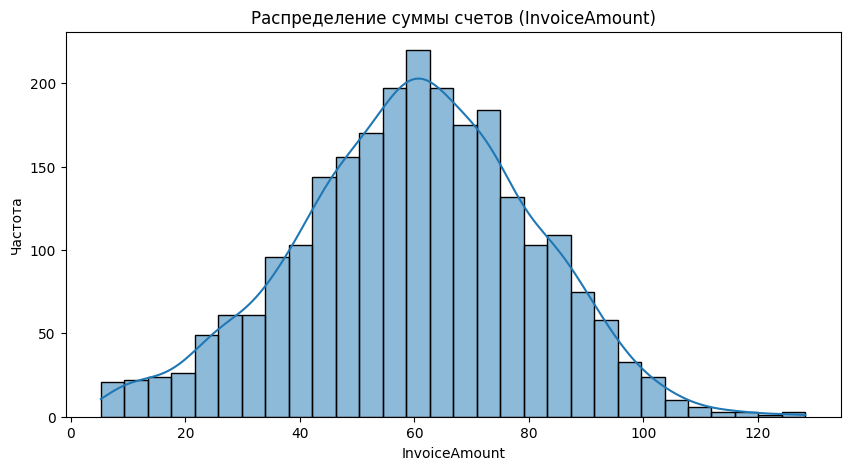

In [9]:
plt.figure(figsize=(10, 5))
sns.histplot(data['InvoiceAmount'], bins=30, kde=True)
plt.title("Распределение суммы счетов (InvoiceAmount)")
plt.xlabel("InvoiceAmount")
plt.ylabel("Частота")
plt.show()

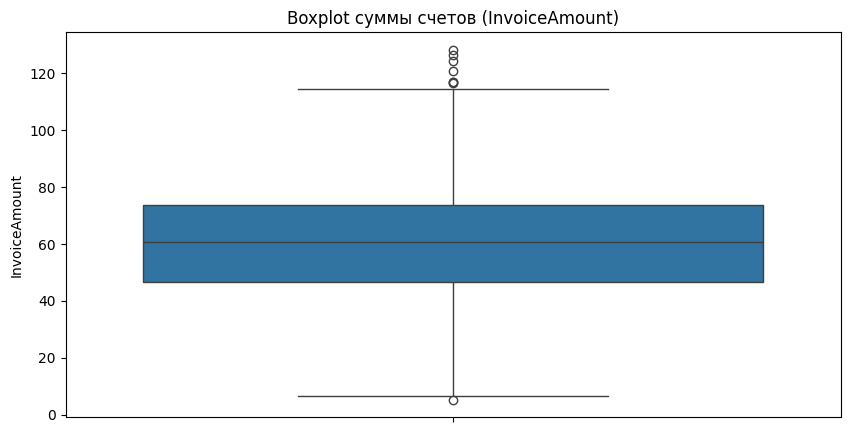

In [10]:
plt.figure(figsize=(10, 5))
sns.boxplot(data['InvoiceAmount'])
plt.title("Boxplot суммы счетов (InvoiceAmount)")
plt.show()

**Вывод:** Суммы счетов распределены в основном равномерно, но есть маленькое количество выбросов которые можно обработать логарифмируя значения сумм. 

Теперь рассмотрим распределение просрочек платежа

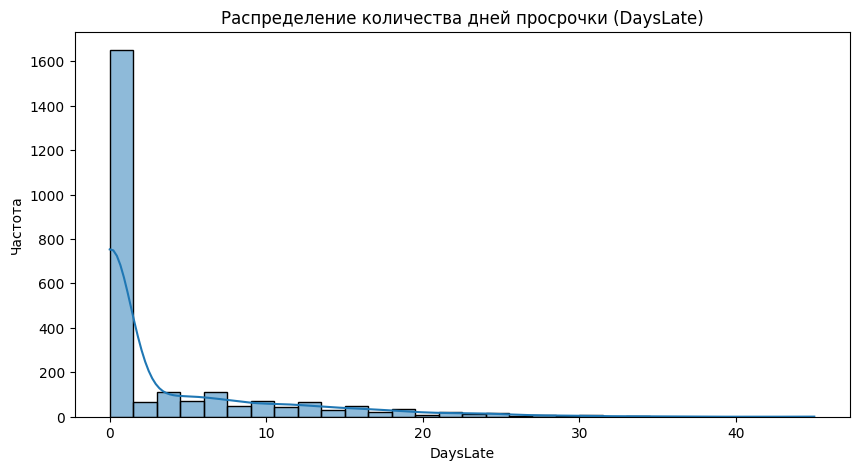

In [11]:
plt.figure(figsize=(10, 5))
sns.histplot(data['DaysLate'], bins=30, kde=True)
plt.title("Распределение количества дней просрочки (DaysLate)")
plt.xlabel("DaysLate")
plt.ylabel("Частота")
plt.show()

**Вывод:** Большинство значений близко к 0, что подтверждает, что большинство платежей осуществляется вовремя. Есть длинный хвост для значительных задержек (10+ дней).

### **1.1. Исследование влияния категориальных признаков на просрочку**

Влияние `PaperlessBill` на `DaysLate`

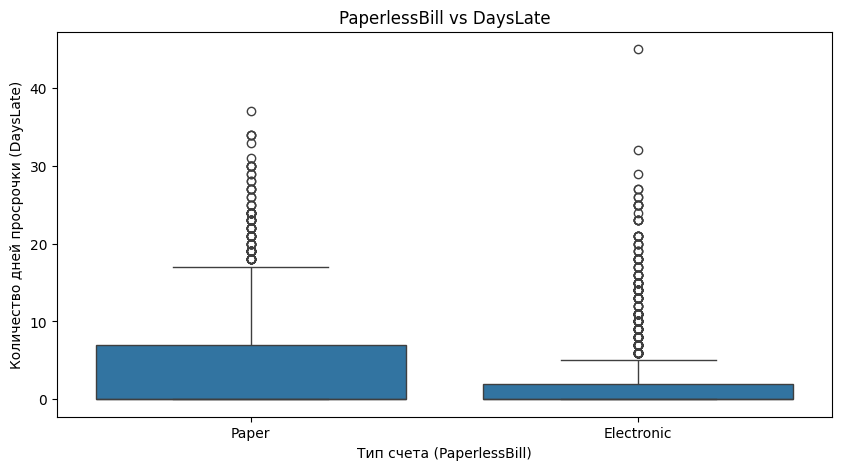

In [12]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='PaperlessBill', y='DaysLate', data=data)
plt.title("PaperlessBill vs DaysLate")
plt.xlabel("Тип счета (PaperlessBill)")
plt.ylabel("Количество дней просрочки (DaysLate)")
plt.show()

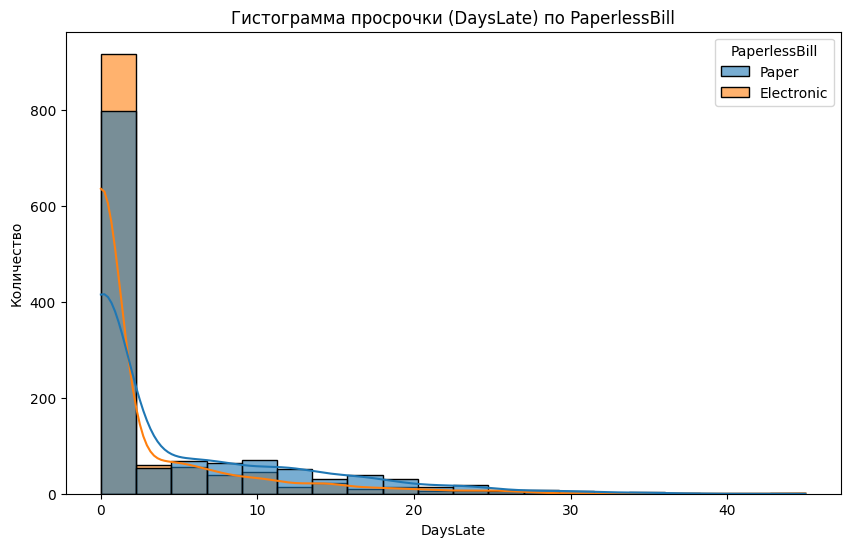

In [13]:
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='DaysLate', hue='PaperlessBill', bins=20, kde=True, alpha=0.6)
plt.title("Гистограмма просрочки (DaysLate) по PaperlessBill")
plt.xlabel("DaysLate")
plt.ylabel("Количество")
plt.show()

**Вывод:** Электронные счета `Electronic` имеют меньшую вероятность задержки. Основная масса счетов имеет `DaysLate` близким к нулю.
Бумажные счета `Paper` демонстрируют большее количество задержек по сравнению с электронными счетами, что заметно по более длинному хвосту в распределении.

Влияние `Disputed` на `DaysLate`

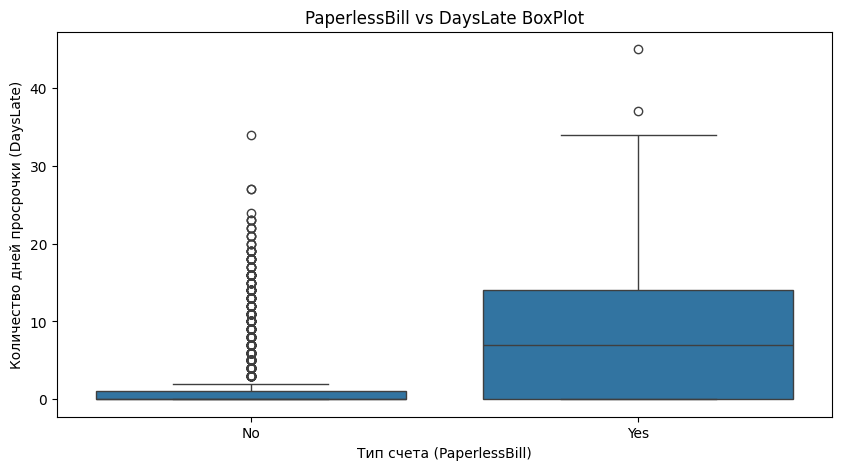

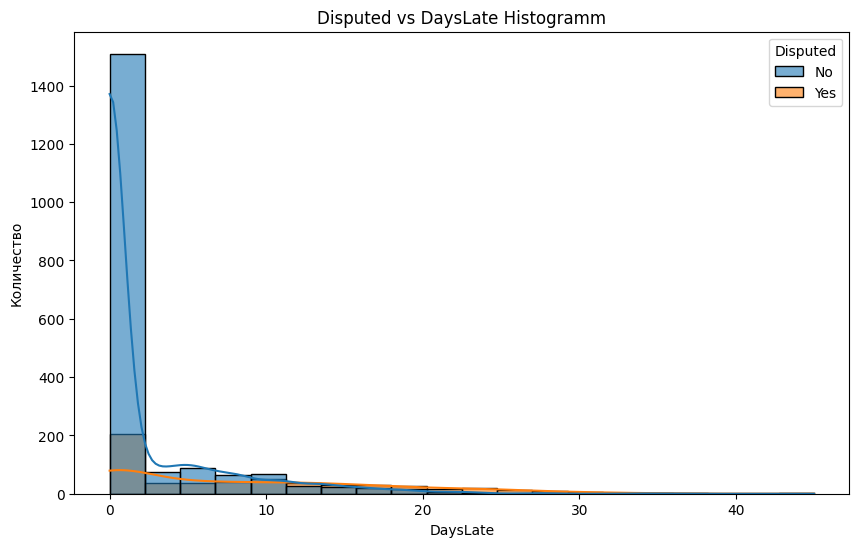

In [14]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='Disputed', y='DaysLate', data=data)
plt.title("PaperlessBill vs DaysLate BoxPlot")
plt.xlabel("Тип счета (PaperlessBill)")
plt.ylabel("Количество дней просрочки (DaysLate)")
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='DaysLate', hue='Disputed', bins=20, kde=True, alpha=0.6)
plt.title("Disputed vs DaysLate Histogramm")
plt.xlabel("DaysLate")
plt.ylabel("Количество")
plt.show()

**Вывод:** Оспоренные счета имеют больше вероятность просрочки платежа, чем неоспоренные

### **1.2. Коррекция датасета для обучения модели**

Прологорифмуем все `InvoiceAmount` для обработки выбросов

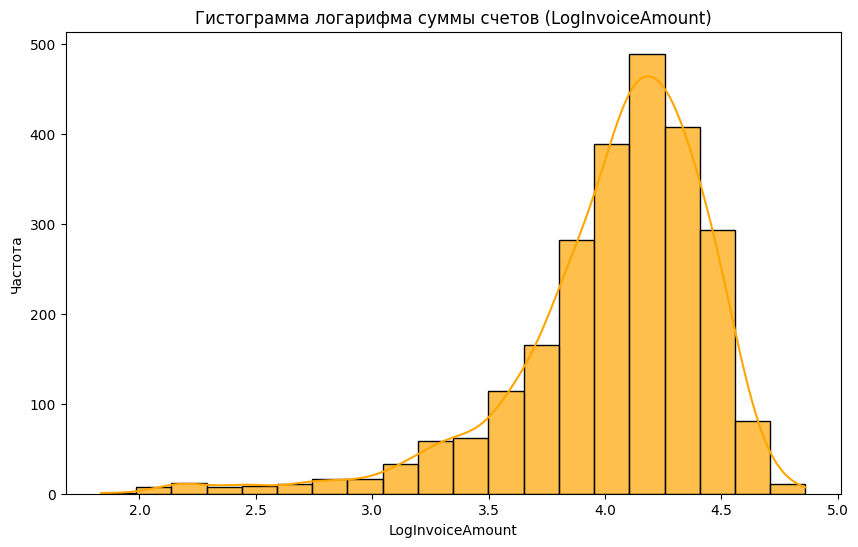

In [15]:
data['LogInvoiceAmount'] = np.log1p(data['InvoiceAmount'])

plt.figure(figsize=(10, 6))
sns.histplot(data['LogInvoiceAmount'], bins=20, kde=True, color='orange', alpha=0.7)
plt.title("Гистограмма логарифма суммы счетов (LogInvoiceAmount)")
plt.xlabel("LogInvoiceAmount")
plt.ylabel("Частота")
plt.show()

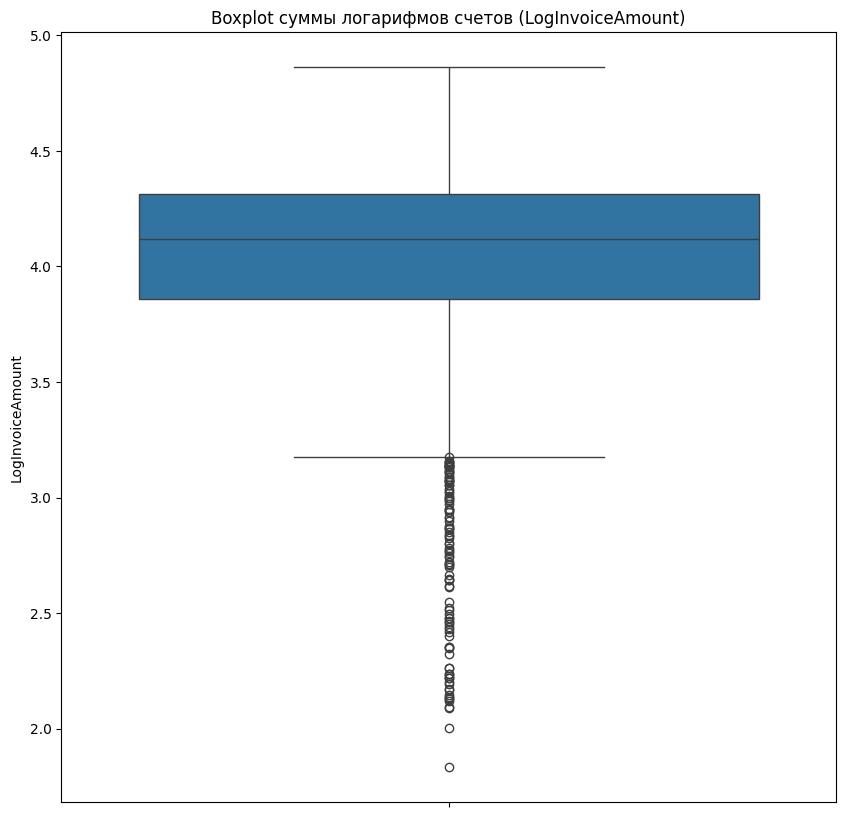

In [16]:
plt.figure(figsize=(10, 10))
sns.boxplot(data['LogInvoiceAmount'])
plt.title("Boxplot суммы логарифмов счетов (LogInvoiceAmount)")
plt.show()

После логарифмирования нет слишком больших счетов, которые бы могли сильно повлиять на обучения модели.

Далее превратим категориальные признаки в числовые используя `one-hot encoding`, чтобы модель сумела на их основе обучиться.

In [17]:
data_encoded = pd.get_dummies(data[['countryCode', 'LogInvoiceAmount','DaysLate', 'OnTimePayment','PaperlessBill','Disputed']], drop_first=True)
data_encoded

,countryCode,LogInvoiceAmount,DaysLate,OnTimePayment,PaperlessBill_Paper,Disputed_Yes
0,391,4.041998,0,0,True,False
1,406,4.138999,6,1,False,True
2,391,4.202900,0,0,False,False
3,406,4.672081,5,1,False,False
4,818,4.294151,4,1,True,True
...,...,...,...,...,...,...
2461,391,4.389623,14,1,False,False
2462,391,3.669951,0,0,True,False
2463,770,4.228147,0,0,True,False
2464,770,3.991943,0,0,True,False


## **2. Обучение модели**

Разделение на обучающие и тестовые выборки

In [18]:
X = data_encoded.drop(columns=['DaysLate', 'OnTimePayment'])
y = data_encoded['OnTimePayment'] 
y_reg = data_encoded[['DaysLate']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)

Для данной задачин было решено использовать 3 алгоритма и сравнить результаты.

## **2.1. KNN**
Для данной задачи классификации было решено использовать алгоритм KNN (K-Nearest-Neighbours), так-как это простой, но мощный алгоритм, который может хорошо работать с небольшими или умеренными наборами данных. Он классифицирует объект на основе метрики близости к соседним объектам. 

#### Нормализация данных
Нормализация выравнивает масштабы данных, что важно для KNN, так как он основан на расстояниях.

In [19]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)

y_pred = knn_model.predict(X_test_scaled)

Оценка качества

In [20]:
accuracy_knn = accuracy_score(y_test, y_pred)
print(f"Точность модели KNN: {accuracy_knn:.2f}")

report = classification_report(y_test, y_pred)
print("Отчет классификации:")
print(report)

Точность модели KNN: 0.71
Отчет классификации:
              precision    recall  f1-score   support

           0       0.74      0.83      0.79       321
           1       0.60      0.47      0.53       173

    accuracy                           0.71       494
   macro avg       0.67      0.65      0.66       494
weighted avg       0.70      0.71      0.70       494



Для улучшения модели попытаемся выбрать оптимальное количество соседей

In [21]:
param_grid = {'n_neighbors': range(1, 50)}
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

best_k = grid_search.best_params_['n_neighbors']
print(f"Лучшее значение k: {best_k}")

best_knn_accuracy = grid_search.best_score_
print(f"Точность с оптимальным k: {best_knn_accuracy:.2f}")

Лучшее значение k: 34
Точность с оптимальным k: 0.73


**Вывод:** С помощью алгоритма KNN мы смогли достичь точности в 73%.

## **2.2. RandomForest**

Как 2-й подход для решения данной задачи был выбран RandomForest, так-как этот подход для классификации или регрессии является хорошим выбором в ряде случаев из-за его характеристик.
С помощью нее мы не только решили не только предугадать будет ли задолженность просрочена или нет, но еще и предсказать на сколько дней.

### **2.2.1. RandomForest Classifier**

In [22]:
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred_reg = rf_classifier.predict(X_test)

accuracy_rf_class = accuracy_score(y_test, y_pred)
print(f"Точность модели: {accuracy_rf_class:.2f}")

report = classification_report(y_test, y_pred)
print("Отчет классификации:")
print(report)

Точность модели: 0.71
Отчет классификации:
              precision    recall  f1-score   support

           0       0.74      0.83      0.79       321
           1       0.60      0.47      0.53       173

    accuracy                           0.71       494
   macro avg       0.67      0.65      0.66       494
weighted avg       0.70      0.71      0.70       494



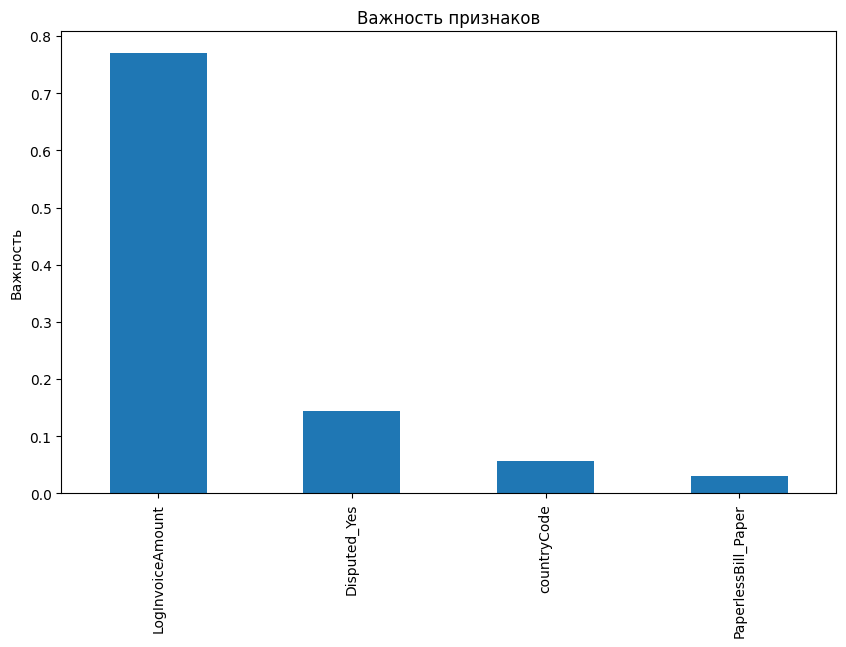

In [23]:
feature_importances = pd.Series(rf_classifier.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=False, inplace=True)

# Визуализация важности признаков
plt.figure(figsize=(10, 6))
feature_importances.plot(kind='bar')
plt.title("Важность признаков")
plt.ylabel("Важность")
plt.show()

**Вывод:** 
+ Общий обзор предсказаний
    * 74% объектов, предсказанных как "оплачено вовремя", действительно принадлежат этому классу.
    * 83% всех объектов класса "оплачено вовремя" модель правильно классифицировала.
    * 60% предсказанных "с просрочкой" действительно имеют задержку.
    * Модель нашла только 47% всех объектов с задержкой.

+ Важность признаков в `Random Forest Regressor`
  - Сумма счета - самый важный признак с важностью около 0.65
  - Оспоренные счета также значительно влияют на задержки платежей ~ 0.2

### **2.2.2. RandomForest Regressor**

In [24]:
rf_regressor = RandomForestRegressor(random_state=42, n_estimators=100)
rf_regressor.fit(X_train_reg, y_train_reg)
y_pred = rf_regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)  # Среднеквадратичная ошибка
mae = mean_absolute_error(y_test, y_pred)  # Средняя абсолютная ошибка
r2 = r2_score(y_test, y_pred)  # Коэффициент детерминации R^2

# Вывод метрик
print(f"Среднеквадратичная ошибка (MSE): {mse:.2f}")
print(f"Средняя абсолютная ошибка (MAE): {mae:.2f}")
print(f"R^2 (коэффициент детерминации): {r2:.2f}")

C:\Users\darbi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Среднеквадратичная ошибка (MSE): 26.99
Средняя абсолютная ошибка (MAE): 3.14
R^2 (коэффициент детерминации): -117.59


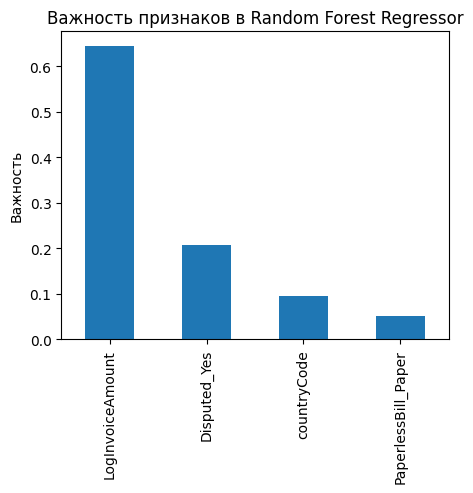

In [25]:
feature_importances = pd.Series(rf_regressor.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(5, 4))
feature_importances.plot(kind='bar')
plt.title("Важность признаков в Random Forest Regressor")
plt.ylabel("Важность")
plt.show()


**Вывод:**
+ Метрики модели `Random Forest Regressor`:
  * Среднеквадратичная ошибка `MSE`: 26.99

    - Это означает, что в среднем квадрат отклонения предсказанных значений `DaysLate` от фактических составляет около 27.
    - `MSE` чувствительна к выбросам: большие ошибки сильнее влияют на итоговую метрику.
  * Средняя абсолютная ошибка `MAE`: 3.14

    - Модель в среднем ошибается примерно на 3.14 дня, что является более интерпретируемой метрикой, чем `MSE`.
    - Это значение указывает на относительное качество модели.
  * Коэффициент детерминации `R²`: -117.59

    - Отрицательное значение `R²` говорит о том, что модель работает хуже, чем простое предсказание среднего значения. Это указывает на проблемы в обучении модели или неподходящие данные.

+ Важность признаков в `Random Forest Regressor`
  - Сумма счета - самый важный признак с важностью около 0.65
  - Оспоренные счета также значительно влияют на задержки платежей ~0.2

### Сравнение точности  2-х моделей классификации

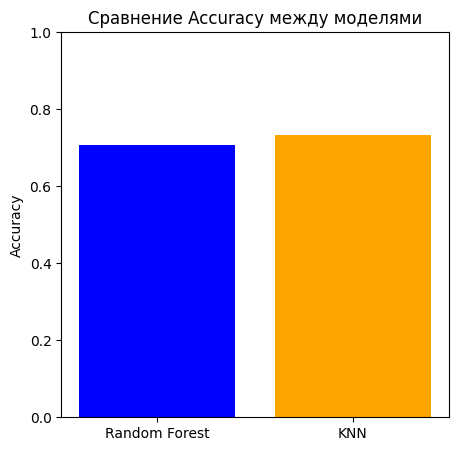

In [26]:
models = ['Random Forest', 'KNN']
accuracies = [accuracy_rf_class, best_knn_accuracy]  

plt.figure(figsize=(5, 5))
plt.bar(models, accuracies, color=['blue', 'orange', 'green'])
plt.title('Сравнение Accuracy между моделями')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

###  ROC-кривая для сравнения моделей классификации
ROC-кривая показывает, насколько хорошо модель различает классы. Она строится на основе метрик True Positive Rate (TPR) и False Positive Rate (FPR).


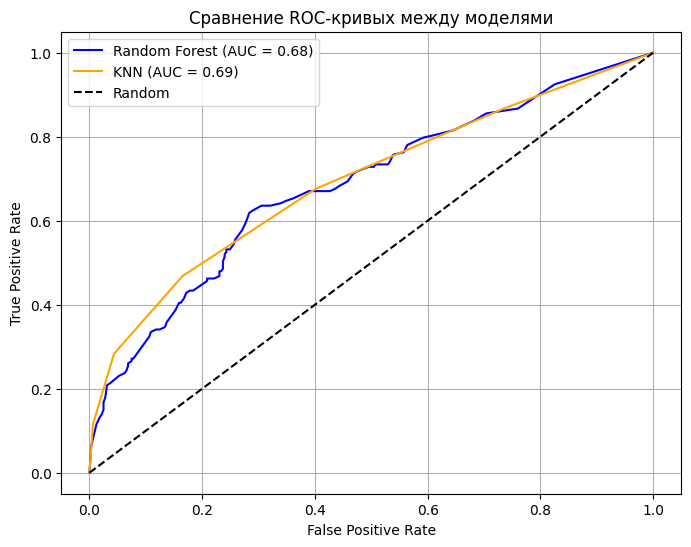

In [27]:
plt.figure(figsize=(8, 6))

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_classifier.predict_proba(X_test)[:, 1])
auc_rf = roc_auc_score(y_test, rf_classifier.predict_proba(X_test)[:, 1])
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})', color='blue')

# KNN
fpr_knn, tpr_knn, _ = roc_curve(y_test, knn_model.predict_proba(X_test_scaled)[:, 1])
auc_knn = roc_auc_score(y_test, knn_model.predict_proba(X_test_scaled)[:, 1])
plt.plot(fpr_knn, tpr_knn, label=f'KNN (AUC = {auc_knn:.2f})', color='orange')

# линия слу
plt.plot([0, 1], [0, 1], 'k--', label='Random')

plt.title('Сравнение ROC-кривых между моделями')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()

**Вывод:** На основе ROC-кривых видно, что модели (Random Forest и KNN) имеют схожую производительность: AUC для KNN составляет 0.69, а для Random Forest — 0.68. Хотя KNN показывает немного лучшее качество, разница минимальна, и обе модели работают лишь чуть лучше случайного предсказания. 

## **2.3. Binary Classification**

Третьим методом будет выступать бинарная классификация, для которой было принято решение более тщательно провести предварительную обработку данных.

In [28]:
data = pd.read_csv('./data/ar_dataset.csv')

Параметр `DaysLate` заменяем бинарным значением 1, если есть опоздание, и 0, если его нет.

In [29]:
data['DaysLate'] = data['DaysLate'].apply(lambda x: 1 if x > 0 else x)

Переменную `DaysToSettle` было решено убрать, так-как приоритетным является предугадание того, будет ли опоздание, а не насколько.

In [30]:
data = data.drop(columns=['DaysToSettle'])
data

,countryCode,customerID,PaperlessDate,invoiceNumber,InvoiceDate,DueDate,InvoiceAmount,Disputed,SettledDate,PaperlessBill,DaysLate
0,391,0379-NEVHP,4/6/2013,611365,1/2/2013,2/1/2013,55.94,No,1/15/2013,Paper,0
1,406,8976-AMJEO,3/3/2012,7900770,1/26/2013,2/25/2013,61.74,Yes,3/3/2013,Electronic,1
2,391,2820-XGXSB,1/26/2012,9231909,7/3/2013,8/2/2013,65.88,No,7/8/2013,Electronic,0
3,406,9322-YCTQO,4/6/2012,9888306,2/10/2013,3/12/2013,105.92,No,3/17/2013,Electronic,1
4,818,6627-ELFBK,11/26/2012,15752855,10/25/2012,11/24/2012,72.27,Yes,11/28/2012,Paper,1
...,...,...,...,...,...,...,...,...,...,...,...
2461,391,6708-DPYTF,8/2/2012,9982796720,10/18/2013,11/17/2013,79.61,No,12/1/2013,Electronic,1
2462,391,9841-XLGBV,1/3/2013,9983237240,9/19/2012,10/19/2012,38.25,No,10/13/2012,Paper,0
2463,770,7856-ODQFO,8/5/2012,9986249860,7/2/2012,8/1/2012,67.59,No,7/27/2012,Paper,0
2464,770,7050-KQLDO,9/29/2012,9989225541,4/27/2012,5/27/2012,53.16,No,5/18/2012,Paper,0


Далее, опять же для улучшения точности модели было решено разделить на отдельные столбцы все даты в таблице. Для этого реализована функция `split_date_column`.

In [31]:
def split_date_column(data, date_column):
    data[date_column] = pd.to_datetime(data[date_column], format='%m/%d/%Y')

    base_name = date_column[:-4]  # Удаляем суффикс "Date"
    new_columns = {
        f'{base_name}Day': data[date_column].dt.day,
        f'{base_name}Month': data[date_column].dt.month,
        f'{base_name}Year': data[date_column].dt.year
    }

    original_columns = data.columns.tolist()

    date_col_index = original_columns.index(date_column)

    data.drop(columns=[date_column], inplace=True)

    # Вставляем обратно в правильном порядке
    for i, (col_name, col_data) in enumerate(new_columns.items()):
        data.insert(date_col_index + i, col_name, col_data)

    return data

Применяем функцию.

In [32]:
data = split_date_column(data, 'PaperlessDate')
data = split_date_column(data, 'InvoiceDate')
data = split_date_column(data, 'SettledDate')
data = split_date_column(data, 'DueDate')

data

,countryCode,customerID,PaperlessDay,PaperlessMonth,PaperlessYear,invoiceNumber,InvoiceDay,InvoiceMonth,InvoiceYear,DueDay,DueMonth,DueYear,InvoiceAmount,Disputed,SettledDay,SettledMonth,SettledYear,PaperlessBill,DaysLate
0,391,0379-NEVHP,6,4,2013,611365,2,1,2013,1,2,2013,55.94,No,15,1,2013,Paper,0
1,406,8976-AMJEO,3,3,2012,7900770,26,1,2013,25,2,2013,61.74,Yes,3,3,2013,Electronic,1
2,391,2820-XGXSB,26,1,2012,9231909,3,7,2013,2,8,2013,65.88,No,8,7,2013,Electronic,0
3,406,9322-YCTQO,6,4,2012,9888306,10,2,2013,12,3,2013,105.92,No,17,3,2013,Electronic,1
4,818,6627-ELFBK,26,11,2012,15752855,25,10,2012,24,11,2012,72.27,Yes,28,11,2012,Paper,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2461,391,6708-DPYTF,2,8,2012,9982796720,18,10,2013,17,11,2013,79.61,No,1,12,2013,Electronic,1
2462,391,9841-XLGBV,3,1,2013,9983237240,19,9,2012,19,10,2012,38.25,No,13,10,2012,Paper,0
2463,770,7856-ODQFO,5,8,2012,9986249860,2,7,2012,1,8,2012,67.59,No,27,7,2012,Paper,0
2464,770,7050-KQLDO,29,9,2012,9989225541,27,4,2012,27,5,2012,53.16,No,18,5,2012,Paper,0


Также было решено сделать бинарным параметр `Disputed` для уменьшения предвзятости модели.

In [33]:
data['Disputed'] = data['Disputed'].apply(lambda x: 1 if x == 'Yes' else 0)


Приведем `countryCode`, `customerID`, `PaperlessBill`, `Disputed` к категоральному типу, так-как значения у этих столбцов дискретные.

In [34]:
columns_to_change = ['countryCode', 'customerID', 'PaperlessBill', 'Disputed']
data[columns_to_change] = data[columns_to_change].astype('category')

В итоге получаем данную таблицу

In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2466 entries, 0 to 2465
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   countryCode     2466 non-null   category
 1   customerID      2466 non-null   category
 2   PaperlessDay    2466 non-null   int32   
 3   PaperlessMonth  2466 non-null   int32   
 4   PaperlessYear   2466 non-null   int32   
 5   invoiceNumber   2466 non-null   int64   
 6   InvoiceDay      2466 non-null   int32   
 7   InvoiceMonth    2466 non-null   int32   
 8   InvoiceYear     2466 non-null   int32   
 9   DueDay          2466 non-null   int32   
 10  DueMonth        2466 non-null   int32   
 11  DueYear         2466 non-null   int32   
 12  InvoiceAmount   2466 non-null   float64 
 13  Disputed        2466 non-null   category
 14  SettledDay      2466 non-null   int32   
 15  SettledMonth    2466 non-null   int32   
 16  SettledYear     2466 non-null   int32   
 17  PaperlessBill 

Для обучения с разными параметрами и для подбора наилучших параметров написаны следующие функции

+ `prepare_data`: Разделяет входные данные на тренировочную и тестовую выборки

In [36]:
def prepare_data(data, target, cat_features, test_size=0.5, random_state=42):
    X = data.drop(columns=[target])
    y = data[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test, cat_features

+ `objective`: Используется Optuna для оптимизации гиперпараметров. Она обучает модель с текущими параметрами, оценивает её с помощью `ROC AUC` и возвращает результат. Ключевые параметры задаются с помощью методов `suggest_*`.

In [37]:
def objective(trial, X_train, X_test, y_train, y_test, cat_features):
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1000),  # Количество итераций
        "depth": trial.suggest_int("depth", 4, 12),  # Глубина деревьев
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.5, log=True),  # Скорость обучения
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10),  # Регуляризация
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0, 1),  # Температура bagging
        "border_count": trial.suggest_int("border_count", 1, 255),  # Количество границ для разбиений
        "random_strength": trial.suggest_float("random_strength", 1e-4, 10, log=True),  # Сила рандомизации
        "verbose": 0,  # Отключение вывода логов
        "eval_metric": "AUC",  # Метрика оценки
        "task_type": "CPU",  # Выбор устройства (CPU/GPU)
    }
    
    # Создаём CatBoost Pool
    train_pool = Pool(X_train, y_train, cat_features=cat_features)
    test_pool = Pool(X_test, y_test, cat_features=cat_features)

    # Обучение модели CatBoost
    model = CatBoostClassifier(**params)
    model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=50, verbose=False)
    
    # Вычисляем ROC AUC на тестовых данных
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Предсказание вероятностей класса 1
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    return roc_auc

+ `tune_and_train`: Функция
    * Разделяет данные на тренировочные и тестовые.
    * Запускает Optuna для подбора гиперпараметров.
    * Обучает модель с лучшими параметрами.
    * Возвращает обученную модель и оптимальные параметры.


In [38]:
def tune_and_train(data, target, cat_features, n_trials=50):
    # Разделение данных
    X_train, X_test, y_train, y_test, cat_features = prepare_data(data, target, cat_features)
    
    # Создание Optuna-исследования
    study = optuna.create_study(study_name="accounts_receivable_study", direction="maximize")  # Оптимизация на максимум
    study.optimize(lambda trial: objective(trial, X_train, X_test, y_train, y_test, cat_features), n_trials=n_trials)

    # Вывод лучших параметров
    print("Лучшие параметры:", study.best_params)
    print("Лучший показатель ROC AUC:", study.best_value)
    
    # Обучение финальной модели с лучшими параметрами
    best_params = study.best_params
    final_model = CatBoostClassifier(**best_params)
    final_model.fit(Pool(X_train, y_train, cat_features=cat_features), verbose=False)
    
    # Оценка финальной модели
    y_pred_proba = final_model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)
   
    return final_model, study.best_params

Применяем вышеупомянутые фукнции, указывая категоральные признаки, и получаем

In [39]:
cat_features = ['countryCode', 'customerID', 'PaperlessBill', 'Disputed']

final_model, best_params = tune_and_train(data, target="DaysLate", cat_features=cat_features)

print("Итоговые лучшие параметры:", best_params)

[I 2024-12-02 22:49:51,801] A new study created in memory with name: accounts_receivable_study


[I 2024-12-02 22:49:58,752] Trial 0 finished with value: 0.9364301911986463 and parameters: {'iterations': 348, 'depth': 9, 'learning_rate': 0.0035191464472149976, 'l2_leaf_reg': 5.990253911576051, 'bagging_temperature': 0.897186379922127, 'border_count': 142, 'random_strength': 0.0026650447241036825}. Best is trial 0 with value: 0.9364301911986463.
[I 2024-12-02 22:50:06,265] Trial 1 finished with value: 0.9540162075673684 and parameters: {'iterations': 130, 'depth': 8, 'learning_rate': 0.12373270128283559, 'l2_leaf_reg': 5.863488358869457, 'bagging_temperature': 0.07624069563737423, 'border_count': 190, 'random_strength': 0.00039196174045530625}. Best is trial 1 with value: 0.9540162075673684.
[I 2024-12-02 22:50:20,402] Trial 2 finished with value: 0.9557773991919237 and parameters: {'iterations': 385, 'depth': 7, 'learning_rate': 0.0351813423563606, 'l2_leaf_reg': 8.747134709871887, 'bagging_temperature': 0.617677498949157, 'border_count': 45, 'random_strength': 6.110134348918824}.

Лучшие параметры: {'iterations': 494, 'depth': 4, 'learning_rate': 0.212960043672289, 'l2_leaf_reg': 2.809244328951405, 'bagging_temperature': 0.42047826139266214, 'border_count': 205, 'random_strength': 0.7474439606413531}
Лучший показатель ROC AUC: 0.9788541894489657
Итоговые лучшие параметры: {'iterations': 494, 'depth': 4, 'learning_rate': 0.212960043672289, 'l2_leaf_reg': 2.809244328951405, 'bagging_temperature': 0.42047826139266214, 'border_count': 205, 'random_strength': 0.7474439606413531}
